#### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:white; font-size:180%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > Contenido <br><div> 

* [1. Carga de librerías y datos](#1)
    * [1.a. Librerías](#1a)
    * [1.b. Funciones](#1b)
    * [1.c. Carga de datos](#1c)
* [2. Cálculo vulnerabilidad](#2)
    * [2.a. Visualización](#2a)


<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > 1. Carga de librerías y datos<br><div>

<a id="1a"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > 1.a. Librerías<br><div>

In [1]:
import plotly.express as px
import plotly.graph_objs as go
import pandas as pd
from scipy.stats import zscore

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape, MultiPolygon
import unicodedata
import re
import json
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import warnings
warnings.filterwarnings('ignore')

<a id="1b"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > 1.b. Funciones<br><div>

In [2]:
def calculo_metrica(df_localizacion, df_poblacion, distancias):
    """
    La función `calculo_metrica` calcula un índice de vulnerabilidad combinando datos de distancia,
    número de estaciones y población para diferentes distritos. 

    Parámetros:
    - df_localizacion: DataFrame con información sobre la localización de estaciones.
    - df_poblacion: DataFrame con información sobre la cantidad de población en cada distrito.
    - distancias: DataFrame con la media y la mediana de las distancias por distrito.

    Retorna:
    - df_vulnerabilidad: DataFrame con datos originales y la vulnerabilidad final calculada.
    - df_vulnerabilidad_escalada: DataFrame con los valores normalizados.
    - vulnerabilidad_ordenada: Serie con la vulnerabilidad final ordenada por distrito.
    """

    distancias = distancias.set_index('distrito')['mediana']
    estaciones = df_localizacion.groupby('distrito')['station_id'].nunique()
    poblacion = df_poblacion.set_index('distrito').reindex(distancias.index)['poblacion']
    
    df_vulnerabilidad = pd.DataFrame({
        'distancias': distancias,
        'estaciones': estaciones,
        'poblacion': poblacion
    })

    # Normalización z-score
    df_vulnerabilidad_escalada = df_vulnerabilidad.apply(zscore)
    df_vulnerabilidad_escalada['estaciones'] *= -1  # Negar estaciones porque más es mejor
    df_vulnerabilidad['vulnerabilidad'] = df_vulnerabilidad_escalada.sum(axis=1)

    # Normalización min-max 
    vul_min, vul_max = df_vulnerabilidad['vulnerabilidad'].agg(['min', 'max'])
    df_vulnerabilidad['vulnerabilidad'] = (df_vulnerabilidad['vulnerabilidad'] - vul_min) / (vul_max - vul_min)
    df_vulnerabilidad_escalada['vulnerabilidad'] = df_vulnerabilidad['vulnerabilidad']

    # Ordenar los DataFrames por vulnerabilidad
    df_vulnerabilidad = df_vulnerabilidad.sort_values(by='vulnerabilidad')
    df_vulnerabilidad_escalada = df_vulnerabilidad_escalada.sort_values(by='vulnerabilidad')

    # Vulnerabilidad ordenada
    vulnerabilidad_ordenada = df_vulnerabilidad['vulnerabilidad']

    return df_vulnerabilidad, df_vulnerabilidad_escalada, vulnerabilidad_ordenada


def generar_mapa(geojson_path, vulnerabilidad_df, metric_column='metrica', save_path='vulnerabilidad_distritos.png'):
    """
    Genera un mapa basado en un GeoJSON de distritos y un DataFrame con la métrica de vulnerabilidad.

    Entradas:
    - geojson_path (str): Ruta al archivo GeoJSON que contiene información geoespacial de los distritos.
    - vulnerabilidad_df (pd.DataFrame): DataFrame con la métrica de vulnerabilidad. Debe contener:
    - metric_column (str, opcional): Nombre de la columna en vulnerabilidad_df que contiene la métrica. 
        Por defecto es 'metrica'.
    - save_path (str, opcional): Ruta para guardar la imagen generada. Por defecto, 'vulnerabilidad_distritos.png'.

    Salidas:
    - Gráfico: Mapa con los distritos coloreados según las métricas de vulnerabilidad.
    - Guardado opcional: El mapa puede guardarse como imagen en la ruta especificada en save_path.
    """
    # Cargar y procesar el archivo GeoJSON
    def load_and_process_geojson(filepath):
        with open(filepath, 'r') as file:
            geojson_data = json.load(file)

        features = geojson_data['features']
        geometries = []
        properties = []

        for feature in features:
            geom = shape(feature['geometry'])
            if isinstance(geom, MultiPolygon):
                largest_polygon = max(geom.geoms, key=lambda p: p.area)
                geom = largest_polygon
            geometries.append(geom)
            properties.append(feature['properties'])

        gdf = gpd.GeoDataFrame(properties, geometry=geometries)
        return gdf

    # Normalizar texto 
    def normalize_text(text):
        text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')
        text = re.sub(r'[\xa0³¯]', '', text)
        return text.lower().strip()

    # Cargar el GeoDataFrame de distritos
    districts_gdf = load_and_process_geojson(geojson_path)

    # Normalizar nombres en el GeoDataFrame y el DataFrame de métricas
    districts_gdf['NOM'] = districts_gdf['NOM'].apply(normalize_text)
    vulnerabilidad_df['distrito'] = vulnerabilidad_df['distrito'].apply(normalize_text)

    # Diccionario de corrección
    correcciones = {
        'sants-montjuac': 'sants-montjuic',
        'horta-guinarda': 'horta-guinardo',
        'sant marta\xad': 'sant marti'
    }
    districts_gdf['NOM'] = districts_gdf['NOM'].replace(correcciones)

    # Combinar el GeoDataFrame con el DataFrame de métricas
    districts_gdf = districts_gdf.merge(vulnerabilidad_df, left_on='NOM', right_on='distrito', how='left')
    districts_gdf['idx'] = districts_gdf.index

    # Crear el gráfico
    fig, ax = plt.subplots(figsize=(10, 8))
    districts_gdf.plot(column=metric_column, cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='black', legend=False)

    # Añadir el índice de cada distrito en su centroide
    for idx, row in districts_gdf.iterrows():
        centroid = row['geometry'].centroid
        ax.text(centroid.x, centroid.y, str(idx), ha='center', va='center', fontsize=8, color='black')

    # Crear y añadir la barra de color 
    norm = Normalize(vmin=districts_gdf[metric_column].min(), vmax=districts_gdf[metric_column].max())
    sm = ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical", fraction=0.03, pad=0.1)
    cbar.set_label('')

    # Crear la leyenda 
    handles = [
        mpatches.Patch(color=sm.to_rgba(row['metrica']), label=f"{idx + 1}. {nombres[idx]}")
        for idx, row in districts_gdf.iterrows()
    ]
    ax.legend(handles=handles, title="Distritos", bbox_to_anchor=(1.3, 1), loc='upper left', borderaxespad=0.)

    ax.set_title('Vulnerabilidad por distritos')
    plt.subplots_adjust(right=0.8)
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    # plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

<a id="1c"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > 1.c. Carga de datos<br><div>


Se recupera la localización actual de las estaciones.

In [3]:
localizacion = pd.read_csv('../../../1-DATOS/3-DATOS DE RESULTADOS/ANALISIS DESCRIPTIVO/localización según distritos.csv') 
localizacion = localizacion[['station_id', 'lat', 'lon', 'distrito']]
localizacion['distrito'] = localizacion['distrito'].astype('category')
localizacion.head(5)

,station_id,lat,lon,distrito
0,1.0,41.397978,2.180107,Eixample
1,2.0,41.395488,2.177198,Eixample
2,3.0,41.394156,2.181331,Eixample
3,4.0,41.393317,2.181248,Eixample
4,5.0,41.391103,2.180176,Ciutat Vella


Se recuperan estadísticos sobre la distancia entre estaciones.

In [4]:
# Cargar los datos de distancias
distancias = pd.read_csv("../../../1-DATOS/2-DATOS PROCESADOS/DISTANCIAS/Matriz de distancias.csv", index_col=0)
distancias.index = distancias.index.astype(str)
distancias.columns = distancias.columns.astype(str)

# Filtrado de estaciones
info_distritos = localizacion[['station_id', 'distrito']].copy()
info_distritos['station_id'] = info_distritos['station_id'].astype(str)
station_ids = info_distritos['station_id'].unique()
distancias_filtradas = distancias.loc[station_ids, station_ids]

# Crear submatrices de distancias por distrito
info_distritos.set_index('station_id', inplace=True)
distrito_estaciones = info_distritos.groupby('distrito').groups

def calcular_estadisticas(submatriz):
    """Calcula las estadísticas de mínima distancia de una submatriz."""
    # Calcular la mínima distancia ignorando ceros
    minimas_distancias = submatriz.apply(lambda row: row[row != 0].min(), axis=1)
    media = minimas_distancias.mean()
    mediana = minimas_distancias.median()
    return media, mediana

# Calcular estadísticos por distrito
estadisticas = [
    {'distrito': distrito, 
     'media': calcular_estadisticas(distancias_filtradas.loc[estaciones, estaciones])[0], 
     'mediana': calcular_estadisticas(distancias_filtradas.loc[estaciones, estaciones])[1]}
    for distrito, estaciones in distrito_estaciones.items()
]

# Crear DataFrame de estadísticos
estadisticas_distritos = pd.DataFrame(estadisticas)
estadisticas_distritos.head(5)


,distrito,media,mediana
0,Ciutat Vella,400.516667,259.0
1,Eixample,349.546296,307.0
2,Gràcia,556.000000,556.5
3,Horta-Guinardó,529.121212,487.0
4,Les Corts,479.514286,442.0


Se recupera la población por distritos.

In [5]:
nombres = ['Ciutat Vella', 'Eixample', 'Sants-Montjuïc', 'Les Corts','Sarrià-Sant Gervasi', 'Gràcia', 'Horta-Guinardó', 'Nou Barris', 'Sant Andreu', 'Sant Martí']

poblacion = pd.read_csv('../../../1-DATOS/2-DATOS PROCESADOS/POBLACION/Poblacion_distritos_por_edad.csv')[['Distritos','TOTAL']]
poblacion = poblacion.iloc[1:11, :]
poblacion.rename(columns={'Distritos': 'distrito', 'TOTAL': 'poblacion'}, inplace=True)
poblacion.distrito = nombres
poblacion.head(5)

,distrito,poblacion
1,Ciutat Vella,106446
2,Eixample,268824
3,Sants-Montjuïc,185963
4,Les Corts,82154
5,Sarrià-Sant Gervasi,149804


<a id="2"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > 2. Cálculo vulnerabilidad<br><div>

In [6]:
df_vulnerabilidad, df_vulnerabilidad_escalada, vulnerabilidad = calculo_metrica(localizacion, poblacion, estadisticas_distritos[['distrito', 'mediana']])   
df_vulnerabilidad

,distancias,estaciones,poblacion,vulnerabilidad
distrito,,,,
Ciutat Vella,259.0,60,106446,0.000000
Eixample,307.0,108,268824,0.321987
Les Corts,442.0,35,82154,0.516660
Sant Martí,409.5,88,242752,0.611959
Sant Andreu,446.0,47,151799,0.679539
Sarrià-Sant Gervasi,428.5,36,149804,0.712928
Sants-Montjuïc,464.5,54,185963,0.789113
Horta-Guinardó,487.0,33,175550,0.957774
Nou Barris,486.0,29,174215,0.980065


<a id="2a"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color: white; font-size:120%; text-align:left;padding:3.0px; background: maroon; border-bottom: 8px solid black" > 2.a. Visualización<br><div>

In [7]:
vulnerabilidad = vulnerabilidad.reset_index()
vulnerabilidad.columns = ['distrito', 'metrica']
vulnerabilidad['distrito'] = pd.Categorical(vulnerabilidad['distrito'], categories=nombres, ordered=True)
vulnerabilidad = vulnerabilidad.sort_values('distrito')

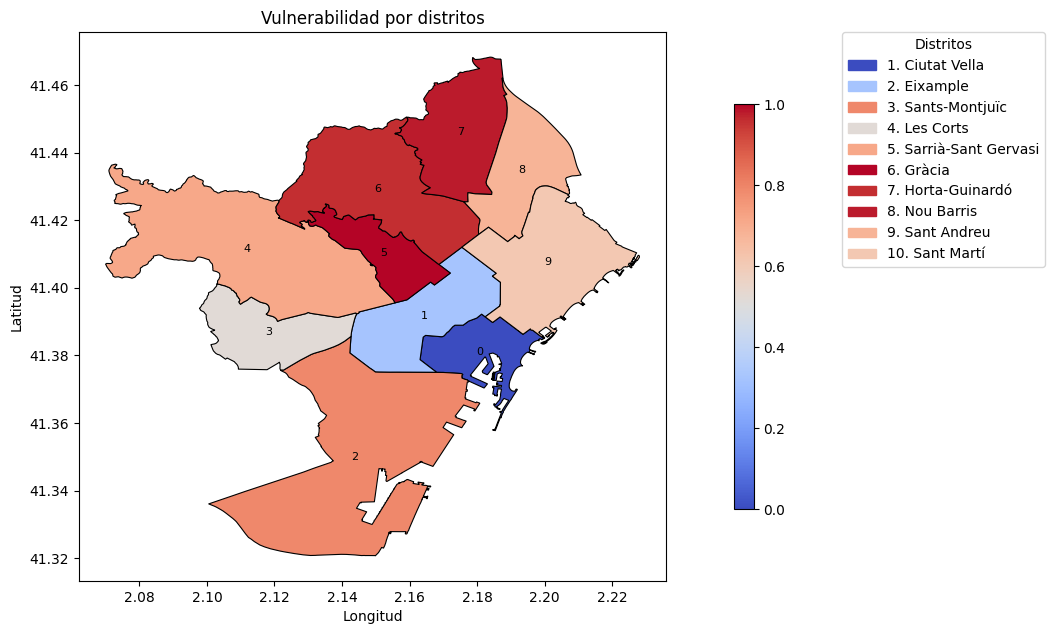

In [8]:
generar_mapa('../../../1-DATOS/2-DATOS PROCESADOS/GEOPORTAL/districtes.geojson', vulnerabilidad, metric_column='metrica', save_path='vulnerabilidad_prueba.png')